In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import networkx as nx

from run_classroom_seating import get_seat_blocking
from classroom_seating import ClassroomModel

In [63]:
"""
Model Parameters
"""
seed = 0
# The classroom layout
blocks = [10, 15, 10]
num_rows = 20

# The social network of Students
cliques = 60
clique_size = 6
max_num_agents = cliques * clique_size
prob_linked_cliques = 0.3
social_network = nx.to_numpy_matrix(nx.relaxed_caveman_graph(cliques, clique_size, prob_linked_cliques, seed))

num_iterations = max_num_agents

model_real = ClassroomModel(max_num_agents, num_rows, blocks, seed, True, False, social_network)

In [5]:
"""
Run model and save locally
"""
def run_model(model, path):
    for i in range(num_iterations):
        model.step()

    model_state = get_seat_blocking(model, [True, True, True])

    with open(path, "wb") as f:
        pkl.dump(model_state, f)

### Generate Data

In [48]:
"""
Model Names:

 - model_b##.pkl : random 
 - model_bs##.pkl : random + sociability
 - model_bsf##.pkl : random + sociability + friendship (60 cliques, size 6, total = 360) 
 - model_bsf_social2_##.pkl : random + sociability + friendship (180 cliques, size 2, total = 360) 
 - model_bsf_theater2_##.pkl : random + sociability + friendship (60 cliques, size 6, total = 360, blocks = [0, 10, 25]) 
 
"""


num_of_samples = 20
# create a "real" model to test
# run_model(model_real, "real_model.pkl")

# generate a bunch of similar models

for i in range(num_of_samples):
    print(i)
    model = ClassroomModel(max_num_agents, num_rows, blocks, i**2+1, True, False, social_network)

    run_model(model, "./test_models/model_bsf_theater2_%s.pkl"%i)

# # generate a bunch of disimilar models
# for i in range(num_of_samples):
#     print(i)
#     model = ClassroomModel(max_num_agents, num_rows, blocks, i**2+1, True, False)

#     run_model(model, "./test_models/model_bs%s.pkl"%i)

# for i in np.arange(14, num_of_samples):
#     print(i)
#     model = ClassroomModel(max_num_agents, num_rows, blocks, i**2+1, False, False)

#     run_model(model, "./test_models/model_b%s.pkl"%i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [64]:
"""
Reduces model to a 1 if seat full, otherwise 0, and strips aisles
"""
def reduce_model_state(model_state):
    # assumes model uses blocks as set above
    # width = sum(blocks)
    # height = num_rows - 1   # remove the horizontal aisle

    result = np.copy(model_state)
    aisles = np.cumsum(blocks)[:-1]

    for a in aisles:
        result = np.delete(result, a, 1)
    result = np.delete(result, 0, 0)

    for seat in np.nditer(result, op_flags=['readwrite']):
        seat[...] = 1 if seat > 0 else 0

    return result


"""
Returns count of each length of cluster

Args:
    model_state: Model state WITHOUT aisles (ie reduced)
"""
def count_clusters(model_state):
    count = np.zeros(max(blocks)+1)

    limits = [0] + list(np.cumsum(blocks))

    for row in model_state:
        b = []
        for i in range(len(limits)-1):
            b.append(row[limits[i]:limits[i+1]])

        for block in b:
            c = 0
            for seat in block:
                if seat == 1:
                    c += 1
                else:
                    count[c] += 1
                    c = 0
            count[c] += 1

    return np.delete(count, 0, 0)

In [69]:
with open("./test_models/model_bsf1.pkl", "rb") as f:
    real_model_state = pkl.load(f).T

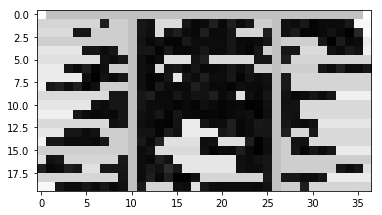

In [70]:
plt.imshow(real_model_state, cmap="Greys")
plt.show()

### Using Cluster MSE

In [77]:
"""
Build profiles of model types
"""

bsf_profile = np.zeros(max(blocks))

for i in range(num_of_samples):
    with open("./test_models/model_bsf%s.pkl"%i, "rb") as f:
        model_state = pkl.load(f).T

    bsf_profile += count_clusters(reduce_model_state(model_state))

bsf_profile /= num_of_samples

bsf_profile_social2 = np.zeros(max(blocks))

for i in range(num_of_samples):
    with open("./test_models/model_bsf_social2_%s.pkl"%i, "rb") as f:
        model_state = pkl.load(f).T

    bsf_profile_social2 += count_clusters(reduce_model_state(model_state))

bsf_profile_social2 /= num_of_samples

bsf_profile_theater2 = np.zeros(max(blocks))

# for i in range(num_of_samples):
#     with open("./test_models/model_bsf_theater2_%s.pkl"%i, "rb") as f:
#         model_state = pkl.load(f).T

#     bsf_profile_theater2 += count_clusters(reduce_model_state(model_state))

# bsf_profile_theater2 /= num_of_samples

bs_profile = np.zeros(max(blocks))

for i in range(num_of_samples):
    with open("./test_models/model_bs%s.pkl"%i, "rb") as f:
        model_state = pkl.load(f).T

    bs_profile += count_clusters(reduce_model_state(model_state))

bs_profile /= num_of_samples

b_profile = np.zeros(max(blocks))

for i in range(num_of_samples):
    with open("./test_models/model_b%s.pkl"%i, "rb") as f:
        model_state = pkl.load(f).T

    b_profile += count_clusters(reduce_model_state(model_state))

b_profile /= num_of_samples

profiles = [bsf_profile, bsf_profile_social2, bs_profile, b_profile]
profile_names = ["BSF", "BSF2", "BS", "B"]

Mean Square Errors between model and profiles:
Model BSF: 	 5.20
Model BSF2: 	 67.16
Model BS: 	 145.15
Model B: 	 166.51


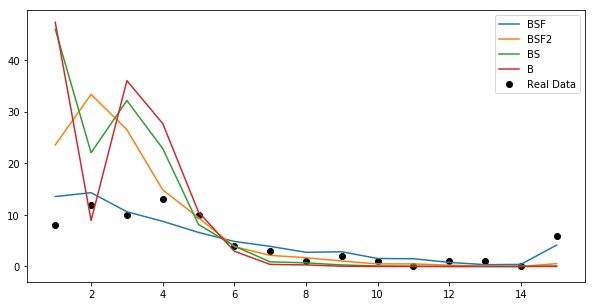

In [89]:
plt.figure(figsize=[10, 5])

with open("./test_models/model_bsf4.pkl", "rb") as f:
    real_model_state = pkl.load(f).T

real_profile = count_clusters(reduce_model_state(real_model_state))
print("Mean Square Errors between model and profiles:")
for i, p in enumerate(profiles):
    mse = ((p - real_profile)**2).mean()
    print("Model %s: \t %.2f"%(profile_names[i], mse))
    plt.plot(np.arange(1, 16), p, label=profile_names[i])

plt.scatter(np.arange(1, 16), real_profile, label="Real Data", c='k')
plt.legend()
plt.show()

In [91]:
classification = np.zeros(len(profiles))

for i in range(num_of_samples):
    with open("./test_models/model_b%s.pkl"%i, "rb") as f:
        model_state = pkl.load(f).T
    
    profile = count_clusters(reduce_model_state(model_state))
    best = 0
    lowest = 100000
    for j in range(len(classification)):
        mse = ((profiles[j] - profile)**2).mean()
        if mse < lowest:
            best = j
            lowest = mse
    
    classification[best] += 1
    
print(classification)

[  0.   0.   1.  19.]


### Using GLCM Texture Analysis

In [18]:
from skimage.feature import greycomatrix, greycoprops
# from skimage import data

In [22]:
patch_real = reduce_model_state(np.array(real_model_state, dtype=np.uint8))

bsf_patches = []
for i in range(10):
    with open("./test_models/model_bsf%s.pkl"%i, "rb") as f:
        model_state = pkl.load(f).T
    
    
    bsf_patches.append(reduce_model_state(np.array(model_state, dtype=np.uint8)))
    
bs_patches = []
for i in range(10):
    with open("./test_models/model_bs%s.pkl"%i, "rb") as f:
        model_state = pkl.load(f).T
        
    bs_patches.append(reduce_model_state(np.array(model_state, dtype=np.uint8)))

b_patches = []
for i in range(10):
    with open("./test_models/model_b%s.pkl"%i, "rb") as f:
        model_state = pkl.load(f).T
        
    b_patches.append(reduce_model_state(np.array(model_state, dtype=np.uint8)))

In [48]:
glcm_real = greycomatrix(b_patches[2], [0, 1, 2, 3], [0, np.pi/2, np.pi], 2, symmetric=True, normed=False)
print(greycoprops(glcm_real, 'energy'))

[[ 1330.  1330.  1330.]
 [ 1292.  1260.  1292.]
 [ 1254.  1190.  1254.]
 [ 1216.  1120.  1216.]]
